In [8]:
import numpy as np
import math
from scipy import stats

# initialize
numdir = 8              # dir groups by increments of 45
numTC  = 30             # 240 total TC cells, 8 direction groups 30 cells each
numRS  = 20             # 160 total RS cells, 8 direction groups 20 cells each
numFS  = 100            # 100 FS cells no direction selectivity 
tRS = numdir * numRS          # total RS cells
tTC = numdir * numTC          # total TC cells
tcells = (tTC + tRS + numFS)  # total cells

# spike probs
tcfsP = 0.65
fsfsP = 0.5
fsrsP = 1     # all to all connectivity
rsrsP = 1     # all to all connectivity

# TC->RS synapse prob by direction difference, 0.35 avg
tcrs0 = 0.7   # 0
tcrs1 = 0.5   # 45
tcrs2 = 0.3   # 90
tcrs3 = 0.15  # 135
tcrs4 = 0.1   # 180

# synaptic delay
tcfsSD = 0
tcrsSD = 0
fsfsSD = 0
fsrsSD = 3
rsrsSD = 2

# amplitudes
fsfsA = 0.1
fsrsA = 0.03
tcfsA = 0.3
tcrsA = 0.04 #0.06
rsrsA = 0 # 0.008

# fs amps w/ bic
fsfsA = 0.1*.025
fsrsA = 0.03*.025

# inc gaba
# fsfsA = 0.1*7
# fsrsA = 0.03*7

# decay rates
tcfsD = 0.73
tcrsD = 0.75
fsfsD = 0.18
fsrsD = 0.18
rsrsD = 0.24

# TC spike prob by direction difference
tcsp0 = 0.8   # 0
tcsp1 = 0.7   # 45
tcsp2 = 0.4   # 90
tcsp3 = 0.15  # 135
tcsp4 = 0.1   # 180

# adjacent whisker spike probs
rsrsAW = .7
rsfsAW = .4

rsrsSDA = 2
rsfsSDA = 2

rsfsD = fsrsD
rsrsAA = 0.006
rsfsAA = 0.08

In [9]:
# parameters
trials = 50
ETIME  = 25.0                 # length of simulation (ms)
TSTEP  = 0.1                  # time step of computation
NSTEPS = int((ETIME/TSTEP)+1) # number of computational steps 
ASIZE  = int(NSTEPS+1)        # array size variable

g_L     = 0.05                # leak conductance
V_rest  = 0                   # resting potential
tau_m   = 20                  # time constant (ms)
tau_ref = 2                   # refractory period (ms)
refsteps  = tau_ref/TSTEP     # refractory period in time steps
threshold = 1                 
maxspikes = 15

PLOTFS = 4                 # PW FS cell number to plot and print statistics for
PLOTRS = 41                 # PW RS cell number to plot and print statistics for
PLOTFSA = 4                 # AW FS cell number to plot and print statistics for
PLOTRSA = 21                 # AW RS cell number to plot and print statistics for
PLOTFS3 = 4                 # AW FS cell number to plot and print statistics for
PLOTRS3 = 29                 # AW RS cell number to plot and print statistics for
defdir = 3
defdirA = 2
defdir3 = 2

# simulate velocities by changing TCsd
TCmean = 8   # mean of TC spike time distribution (ms)
# TCmeanA = 10   # mean of TC spike time distribution (ms)
IDI = 8       # interdeflection interval
TCsd   = 1    # stdev of TC spike time dist: from high to low velocity, 1,1.25,1.5,2,2.5,3 ms

In [10]:
# initialize storage arrays
coupling  = np.zeros((tcells,tcells),dtype=int)     # array of T/F of synapses
couplingA = np.zeros((tcells,tcells),dtype=int)
couplingC = np.zeros((tcells,tcells),dtype=int)
coupling3 = np.zeros((tcells,tcells),dtype=int)
couplingX = np.zeros((tcells,tcells),dtype=int)
tctimes   = np.zeros((tTC))                         # store spike times of each TC cell
tctimesA  = np.zeros((tTC))
tctimes3  = np.zeros((tTC))
time      = np.zeros((ASIZE,))

fsvolt  = np.zeros((numFS,ASIZE))
fsexc   = np.zeros((numFS,ASIZE))
fsinh   = np.zeros((numFS,ASIZE))         
rsvolt  = np.zeros((tRS,ASIZE))
rsinh   = np.zeros((tRS,ASIZE))
rsexc   = np.zeros((tRS,ASIZE))
tcrsexc = np.zeros((tRS,ASIZE))
rsrsexc = np.zeros((tRS,ASIZE))

fsvoltA  = np.zeros((numFS,ASIZE))
fsexcA   = np.zeros((numFS,ASIZE))
fsinhA   = np.zeros((numFS,ASIZE))         
rsvoltA  = np.zeros((tRS,ASIZE))
rsinhA   = np.zeros((tRS,ASIZE))
rsexcA   = np.zeros((tRS,ASIZE))
tcrsexcA = np.zeros((tRS,ASIZE))
rsrsexcA = np.zeros((tRS,ASIZE))

fsvolt3  = np.zeros((numFS,ASIZE))
fsexc3   = np.zeros((numFS,ASIZE))
fsinh3   = np.zeros((numFS,ASIZE))         
rsvolt3  = np.zeros((tRS,ASIZE))
rsinh3   = np.zeros((tRS,ASIZE))
rsexc3   = np.zeros((tRS,ASIZE))
tcrsexc3 = np.zeros((tRS,ASIZE))
rsrsexc3 = np.zeros((tRS,ASIZE))

# temporary storage variables (V, exc, inh) 
fsv   = np.zeros((numFS,2))
fse   = np.zeros((numFS,2))
fsi   = np.zeros((numFS,2))
rsv   = np.zeros((tRS,2))
rsi   = np.zeros((tRS,2))
rse   = np.zeros((tRS,2)) # cross
tcrse = np.zeros((tRS,2))
rsrse = np.zeros((tRS,2))

# temporary storage variables (V, exc, inh) for 2nd barrel
fsvA   = np.zeros((numFS,2))
fseA   = np.zeros((numFS,2))
fsiA   = np.zeros((numFS,2))
rsvA   = np.zeros((tRS,2))
rsiA   = np.zeros((tRS,2))
rseA   = np.zeros((tRS,2)) # cross
rseX   = np.zeros((tRS,2))
tcrseA = np.zeros((tRS,2))
rsrseA = np.zeros((tRS,2))

fsv3   = np.zeros((numFS,2))
fse3   = np.zeros((numFS,2))
fsi3   = np.zeros((numFS,2))
rsv3   = np.zeros((tRS,2))
rsi3   = np.zeros((tRS,2))
rse3   = np.zeros((tRS,2)) # cross
tcrse3 = np.zeros((tRS,2))
rsrse3 = np.zeros((tRS,2))

# track refractory periods for each neuron
fsref = np.zeros((numFS,))
rsref = np.zeros((tRS,))
fsrefA = np.zeros((numFS,))
rsrefA = np.zeros((tRS,))
fsref3 = np.zeros((numFS,))
rsref3 = np.zeros((tRS,))

# track of spike counts of each neuron (all trials)
fsspikecount  = np.zeros((trials,numFS),dtype=int)
rsspikecount  = np.zeros((trials,tRS),dtype=int)
fsspikecountA  = np.zeros((trials,numFS),dtype=int)
rsspikecountA  = np.zeros((trials,tRS),dtype=int)  
fsspikecount3  = np.zeros((trials,numFS),dtype=int)
rsspikecount3  = np.zeros((trials,tRS),dtype=int)  

# keep track of how many spikes have been inputed
fsspiketrack  = np.zeros((numFS,),dtype=int)
fsspiketrack2 = np.zeros((numFS,),dtype=int) 
rsspiketrack  = np.zeros((tRS,),dtype=int) 
fsspiketrackA  = np.zeros((numFS,),dtype=int)
fsspiketrack2A = np.zeros((numFS,),dtype=int) 
rsspiketrackA  = np.zeros((tRS,),dtype=int) 
fsspiketrack3  = np.zeros((numFS,),dtype=int)
fsspiketrack23 = np.zeros((numFS,),dtype=int) 
rsspiketrack3  = np.zeros((tRS,),dtype=int) 

# track spike times of each neuron (all trials)
fsspiketimes  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimes  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
fsspiketimesA  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimesA  = np.full((trials,tRS,maxspikes),-1,dtype=float)  
fsspiketimes3  = np.full((trials,numFS,maxspikes),-1,dtype=float)
rsspiketimes3  = np.full((trials,tRS,maxspikes),-1,dtype=float)  

# 
tempexc = np.zeros((ASIZE,))
tempinh = np.zeros((ASIZE,))
tempsyn = np.zeros((ASIZE,))
tempexcA = np.zeros((ASIZE,))
tempinhA = np.zeros((ASIZE,))
tempsynA = np.zeros((ASIZE,))
tempexc3 = np.zeros((ASIZE,))
tempinh3 = np.zeros((ASIZE,))
tempsyn3 = np.zeros((ASIZE,))

# time,amp of peak tc,rs,exc,inh,syn input to RS cell PLOTRS each trial
tpeak  = np.zeros((trials,2),dtype=float)
rpeak  = np.zeros((trials,2),dtype=float)
epeak  = np.zeros((trials,2),dtype=float)
ipeak  = np.zeros((trials,2),dtype=float)
speak  = np.zeros((trials,2),dtype=float)
fepeak = np.zeros((trials,2),dtype=float)
fsepeak = np.zeros((trials,2),dtype=float)

tpeakA  = np.zeros((trials,2),dtype=float)
rpeakA  = np.zeros((trials,2),dtype=float)
epeakA  = np.zeros((trials,2),dtype=float)
ipeakA  = np.zeros((trials,2),dtype=float)
speakA  = np.zeros((trials,2),dtype=float)
repeakA = np.zeros((trials,2),dtype=float)
fepeakA = np.zeros((trials,2),dtype=float)
fsepeakA = np.zeros((trials,2),dtype=float)

tpeak3  = np.zeros((trials,2),dtype=float)
rpeak3  = np.zeros((trials,2),dtype=float)
epeak3  = np.zeros((trials,2),dtype=float)
ipeak3  = np.zeros((trials,2),dtype=float)
speak3  = np.zeros((trials,2),dtype=float)
repeak3 = np.zeros((trials,2),dtype=float)
fepeak3 = np.zeros((trials,2),dtype=float)
fsepeak3 = np.zeros((trials,2),dtype=float)

In [11]:
SetCoupling(coupling,22)
SetCoupling(couplingA,44)
SetCoupling(coupling3,88)
CrossCoupling(couplingC,66)
CrossCoupling(couplingX,110)
pairedjit = []
pairedspikes = []
interval = []

for z in range(0,41): 
    IDI = .5*z+3

    for trial in range(1, trials+1):
        tctimes  = np.zeros((tTC))
        tctimesA  = np.zeros((tTC))
        tctimes3  = np.zeros((tTC))
        setTCspike(tctimes,defdir,TCmean)
    #     setTCspike(tctimesA,defdirA,TCmean)
        setTCspike(tctimes3,defdir3,TCmean+IDI)
        j = 0  
        x = 0
        y = 0
        temp = 0

        for i in range(1,numFS+1):                            # reset current counters
            fsspikecount[trial-1,i-1]=0
            fsspiketrack[i-1]=0
            fsspiketrack2[i-1]=0
            fsv[i-1,1]=0
            fse[i-1,1]=0
            fsi[i-1,1]=0
            fsref[i-1]=0

            fsspikecountA[trial-1,i-1]=0
            fsspiketrackA[i-1]=0
            fsspiketrack2A[i-1]=0
            fsvA[i-1,1]=0
            fseA[i-1,1]=0
            fsiA[i-1,1]=0
            fsrefA[i-1]=0

            fsspikecount3[trial-1,i-1]=0
            fsspiketrack3[i-1]=0
            fsspiketrack23[i-1]=0
            fsv3[i-1,1]=0
            fse3[i-1,1]=0
            fsi3[i-1,1]=0
            fsref3[i-1]=0

        for i in range(1,tRS+1):
            rsspikecount[trial-1,i-1]=0
            rsspiketrack[i-1]=0
            rsv[i-1,1]=0
            rsi[i-1,1]=0
            rsref[i-1]=0
            tcrse[i-1,1]=0
            rsrse[i-1,1]=0
            rse[i-1,1]=0

            rsspikecountA[trial-1,i-1]=0
            rsspiketrackA[i-1]=0
            rsvA[i-1,1]=0
            rsiA[i-1,1]=0
            rsrefA[i-1]=0
            rsrseA[i-1,1]=0
            tcrseA[i-1,1]=0
            rseA[i-1,1]=0

            rsspikecount3[trial-1,i-1]=0
            rsspiketrack3[i-1]=0
            rsv3[i-1,1]=0
            rsi3[i-1,1]=0
            rsref3[i-1]=0
            rsrse3[i-1,1]=0
            tcrse3[i-1,1]=0
            rse3[i-1,1]=0

        tpeak[trial-1,1] = 0.0
        rpeak[trial-1,1] = 0.0
        epeak[trial-1,1] = 0.0
        ipeak[trial-1,1] = 0.0
        speak[trial-1,1] = 0.0
        fepeak[trial-1,1] = 0.0
        fsepeak[trial-1,1] = 0.0

        tpeakA[trial-1,1] = 0.0
        rpeakA[trial-1,1] = 0.0
        repeakA[trial-1,1] = 0.0
        epeakA[trial-1,1] = 0.0
        ipeakA[trial-1,1] = 0.0
        speakA[trial-1,1] = 0.0
        fepeakA[trial-1,1] = 0.0
        fsepeakA[trial-1,1] = 0.0

        tpeak3[trial-1,1] = 0.0
        rpeak3[trial-1,1] = 0.0
        repeak3[trial-1,1] = 0.0
        epeak3[trial-1,1] = 0.0
        ipeak3[trial-1,1] = 0.0
        speak3[trial-1,1] = 0.0
        fepeak3[trial-1,1] = 0.0
        fsepeak3[trial-1,1] = 0.0

        for i in range(1,NSTEPS+1): 

            for k in range(1, numFS+1):                 # move current time slots into previous time slots
                fsv[k-1,0] = fsv[k-1,1]                 # later use time slots to check if a cell spiked
                fse[k-1,0] = fse[k-1,1]
                fsi[k-1,0] = fsi[k-1,1]
            for k in range(1, tRS+1):
                rsv[k-1,0] = rsv[k-1,1]
                rsi[k-1,0] = rsi[k-1,1]
                rse[k-1,0] = rse[k-1,1]
                tcrse[k-1,0] = tcrse[k-1,1]
                rsrse[k-1,0] = rsrse[k-1,1]

            for k in range(1, numFS+1):                 
                fsvA[k-1,0] = fsvA[k-1,1]
                fseA[k-1,0] = fseA[k-1,1]
                fsiA[k-1,0] = fsiA[k-1,1]
            for k in range(1, tRS+1):
                rsvA[k-1,0] = rsvA[k-1,1]
                rsiA[k-1,0] = rsiA[k-1,1]
                rseA[k-1,0] = rseA[k-1,1]
                tcrseA[k-1,0] = tcrseA[k-1,1]
                rsrseA[k-1,0] = rsrseA[k-1,1]

            for k in range(1, numFS+1):                 
                fsv3[k-1,0] = fsv3[k-1,1]
                fse3[k-1,0] = fse3[k-1,1]
                fsi3[k-1,0] = fsi3[k-1,1]
            for k in range(1, tRS+1):
                rsv3[k-1,0] = rsv3[k-1,1]
                rsi3[k-1,0] = rsi3[k-1,1]
                rse3[k-1,0] = rse3[k-1,1]
                tcrse3[k-1,0] = tcrse3[k-1,1]
                rsrse3[k-1,0] = rsrse3[k-1,1]

            # refractory period
            for k in range(1,numFS+1):                  # track FS refractory period
                if fsref[k-1] >= refsteps: 
                    fsref[k-1] = 0
                if fsref[k-1] != 0: 
                    fsref[k-1] += 1
            for k in range(1, tRS+1):                   # track RS refractory period
                if rsref[k-1] >= refsteps: 
                    rsref[k-1] = 0
                if rsref[k-1] != 0: 
                    rsref[k-1] += 1

            for k in range(1,numFS+1):                  # track FS refractory period
                if fsrefA[k-1] >= refsteps: 
                    fsrefA[k-1] = 0
                if fsrefA[k-1] != 0: 
                    fsrefA[k-1] += 1
            for k in range(1, tRS+1):                   # track RS refractory period
                if rsrefA[k-1] >= refsteps: 
                    rsrefA[k-1] = 0
                if rsrefA[k-1] != 0: 
                    rsrefA[k-1] += 1

            for k in range(1,numFS+1):                  # track FS refractory period
                if fsref3[k-1] >= refsteps: 
                    fsref3[k-1] = 0
                if fsref3[k-1] != 0: 
                    fsref3[k-1] += 1
            for k in range(1, tRS+1):                   # track RS refractory period
                if rsref3[k-1] >= refsteps: 
                    rsref3[k-1] = 0
                if rsref3[k-1] != 0: 
                    rsref3[k-1] += 1

            # barrel 1 V_m
            for k in range(1,numFS+1): 
                if fsref[k-1] != 0:
                    fsv[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(fsv[k-1,0]-V_rest) + fse[k-1,0] - fsi[k-1,0]
                    fsv[k-1,1] = fsv[k-1,0] + TSTEP*dvdt
                fsi[k-1,1] = fsi[k-1,0]*(math.exp(-fsfsD*TSTEP))
                fse[k-1,1] = fse[k-1,0]*(math.exp(-tcfsD*TSTEP))
            for k in range(1,tRS+1): 
                if rsref[k-1] != 0: 
                    rsv[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(rsv[k-1,0]-V_rest) - rsi[k-1,0] + tcrse[k-1,0] + rsrse[k-1,0] + rse[k-1,0]
                    rsv[k-1,1] = rsv[k-1,0] + TSTEP*dvdt
                rsi[k-1,1] = rsi[k-1,0]*(math.exp(-fsrsD*TSTEP))
                rse[k-1,1] = rse[k-1,0]*(math.exp(-rsrsD*TSTEP))
                tcrse[k-1,1] = tcrse[k-1,0]*(math.exp(-tcrsD*TSTEP))
                rsrse[k-1,1] = rsrse[k-1,0]*(math.exp(-rsrsD*TSTEP))

            # barrel 2 V_m
            for k in range(1,numFS+1): 
                if fsrefA[k-1] != 0:
                    fsvA[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(fsvA[k-1,0]-V_rest) + fseA[k-1,0] - fsiA[k-1,0]
                    fsvA[k-1,1] = fsvA[k-1,0] + TSTEP*dvdt
                fsiA[k-1,1] = fsiA[k-1,0]*(math.exp(-fsfsD*TSTEP))
                fseA[k-1,1] = fseA[k-1,0]*(math.exp(-tcfsD*TSTEP))
            for k in range(1,tRS+1): 
                if rsrefA[k-1] != 0: 
                    rsvA[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(rsvA[k-1,0]-V_rest) - rsiA[k-1,0] + rseA[k-1,0] + tcrseA[k-1,0] + rsrseA[k-1,0]
                    rsvA[k-1,1] = rsvA[k-1,0] + TSTEP*dvdt
                rsiA[k-1,1] = rsiA[k-1,0]*(math.exp(-fsrsD*TSTEP))
                rseA[k-1,1] = rseA[k-1,0]*(math.exp(-rsrsD*TSTEP))
                tcrseA[k-1,1] = tcrseA[k-1,0]*(math.exp(-tcrsD*TSTEP))
                rsrseA[k-1,1] = rsrseA[k-1,0]*(math.exp(-rsrsD*TSTEP))

            # barrel 3 V_m
            for k in range(1,numFS+1): 
                if fsref3[k-1] != 0:
                    fsv3[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(fsv3[k-1,0]-V_rest) + fse3[k-1,0] - fsi3[k-1,0]
                    fsv3[k-1,1] = fsv3[k-1,0] + TSTEP*dvdt
                fsi3[k-1,1] = fsi3[k-1,0]*(math.exp(-fsfsD*TSTEP))
                fse3[k-1,1] = fse3[k-1,0]*(math.exp(-tcfsD*TSTEP))
            for k in range(1,tRS+1): 
                if rsref3[k-1] != 0: 
                    rsv3[k-1,1] = V_rest
                else: 
                    dvdt = -g_L*(rsv3[k-1,0]-V_rest) - rsi3[k-1,0] + rse3[k-1,0] + tcrse3[k-1,0] + rsrse3[k-1,0]
                    rsv3[k-1,1] = rsv3[k-1,0] + TSTEP*dvdt
                rsi3[k-1,1] = rsi3[k-1,0]*(math.exp(-fsrsD*TSTEP))
                rse3[k-1,1] = rse3[k-1,0]*(math.exp(-rsrsD*TSTEP))
                tcrse3[k-1,1] = tcrse3[k-1,0]*(math.exp(-tcrsD*TSTEP))
                rsrse3[k-1,1] = rsrse3[k-1,0]*(math.exp(-rsrsD*TSTEP))

    # ===============================================================================================

        # 1st barrel

            for k in range(1,numFS+1):                  # check and track FS spikes
                if (fsv[k-1,1] >= threshold and fsv[k-1,0] < threshold): 
                    fsv[k-1,1] = V_rest
                    fsspikecount[trial-1,k-1] += 1
                    fsspiketimes[trial-1,k-1,fsspikecount[trial-1,k-1]-1] = i*TSTEP
                    fsref[k-1] = 1
            for k in range(1,tRS+1):                    # check and track RS spikes
                if (rsv[k-1,1] >= threshold and rsv[k-1,0] < threshold):
                    rsv[k-1,1] = V_rest
                    rsspikecount[trial-1,k-1] += 1
                    rsspiketimes[trial-1,k-1,rsspikecount[trial-1,k-1]-1] = i*TSTEP
                    rsref[k-1] = 1

            for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                if ((tctimes[k-1] < i*TSTEP) and (tctimes[k-1] > ((i-1) * TSTEP))): 
                    for m in range(tTC+1,(tTC+numFS)+1): 
                        fse[m-tTC-1,1] += tcfsA*(coupling[k-1,m-1])
                    for m in range(tTC+numFS+1,tcells+1): 
                        tcrse[m-(tTC+numFS)-1,1] += tcrsA*coupling[k-1,m-1]

            for k in range(1,numFS+1):                  # calculate FSFS and FSRS synaptic inputs
                temp=fsspiketrack2[k-1]+1               # track FS active in current trial
                for m in range(temp,fsspikecount[trial-1,k-1]+1):
                    if (fsspiketimes[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                        fsspiketimes[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                        fsspiketrack2[k-1] += 1
                        for n in range(1,numFS+1): 
                            fsi[n-1,1] += fsfsA * coupling[tTC+k-1,tTC+n-1]
                temp=fsspiketrack[k-1]+1                # same as above but for FSRS
                for m in range(temp,fsspikecount[trial-1,k-1]+1):
                    if (fsspiketimes[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                        fsspiketimes[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                        fsspiketrack[k-1] += 1
                        for n in range(1,tRS+1):
                            rsi[n-1,1] += fsrsA * coupling[tTC+k-1,tTC+numFS+n-1]

            for k in range(1,tRS+1):                    # calculate RSRS synaptic inputs
                temp=rsspiketrack[k-1]+1
                for m in range(temp,rsspikecount[trial-1,k-1]+1):
                    if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                       ((rsspiketimes[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                        rsspiketrack[k-1] += 1
                        for n in range(1,tRS+1): 
                            rsrse[n-1,1] += rsrsA * coupling[tTC+numFS+k-1,tTC+numFS+n-1]

                    if (((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                       ((rsspiketimes[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                        for n in range(1,tRS+1): 
                            rseA[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                        for n in range(1,numFS+1):
                            fseA[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1] 

            # track of peak time,amp in tc,rs,net exc,inh,syn input to RS cell PLOTRS
            if tcrse[PLOTRS-1,1] > tpeak[trial-1,1]:                              
                tpeak[trial-1,0] = i*TSTEP
                tpeak[trial-1,1] = tcrse[PLOTRS-1,1]
            if rsrse[PLOTRS-1,1] > rpeak[trial-1,1]: 
                rpeak[trial-1,0] = i*TSTEP
                rpeak[trial-1,1] = rsrse[PLOTRS-1,1]
            if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] > epeak[trial-1,1]: 
                epeak[trial-1,0] = i*TSTEP
                epeak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1]
            if rsi[PLOTRS-1,1]   > ipeak[trial-1,1]: 
                ipeak[trial-1,0] = i*TSTEP
                ipeak[trial-1,1] = rsi[PLOTRS-1,1]
            if tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1] > speak[trial-1,1]: 
                speak[trial-1,0] = i*TSTEP
                speak[trial-1,1] = tcrse[PLOTRS-1,1] + rsrse[PLOTRS-1,1] - rsi[PLOTRS-1,1]
            if (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]) != 0:
                if (((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])
                     /(tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))>fepeak[trial-1,1]):
                    fepeak[trial-1,0]= i*TSTEP
                    fepeak[trial-1,1]= ((tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1])/
                                       (tcrse[PLOTRS-1,1]+rsrse[PLOTRS-1,1]+rsi[PLOTRS-1,1]))

            if fse[PLOTRS-1,1] > fsepeak[trial-1,1]: 
                fsepeak[trial-1,0] = i*TSTEP
                fsepeak[trial-1,1] = fseA[PLOTRS-1,1]

            # record everything
            j += 1
            time[j-1] = i*TSTEP
            for k in range(1,numFS+1): 
                fsvolt[k-1,j-1]  = fsv[k-1,1]
                fsinh[k-1,j-1]   = fsi[k-1,1]
                fsexc[k-1,j-1]   = fse[k-1,1]
            for k in range(1,tRS+1): 
                rsvolt[k-1,j-1]  = rsv[k-1,1]
                rsinh[k-1,j-1]   = rsi[k-1,1]
                tcrsexc[k-1,j-1] = tcrse[k-1,1]
                rsrsexc[k-1,j-1] = rsrse[k-1,1]

    # ===============================================================================================   

            # 2nd barrel
            temp = 0

            # check and track spikes
            for k in range(1,numFS+1):
                if (fsvA[k-1,1] >= threshold and fsvA[k-1,0] < threshold): 
                    fsvA[k-1,1] = V_rest
                    fsspikecountA[trial-1,k-1] += 1
                    fsspiketimesA[trial-1,k-1,fsspikecountA[trial-1,k-1]-1] = i*TSTEP
                    fsrefA[k-1] = 1

            for k in range(1,tRS+1):
                if (rsvA[k-1,1] >= threshold and rsvA[k-1,0] < threshold):
                    rsvA[k-1,1] = V_rest
                    rsspikecountA[trial-1,k-1] += 1
                    rsspiketimesA[trial-1,k-1,rsspikecountA[trial-1,k-1]-1] = i*TSTEP
                    rsrefA[k-1] = 1

            for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                if ((tctimesA[k-1] < i*TSTEP) and (tctimesA[k-1] > ((i-1) * TSTEP))): 
                    for m in range(tTC+1,(tTC+numFS)+1): 
                        fseA[m-tTC-1,1] += tcfsA*(couplingA[k-1,m-1])
                    for m in range(tTC+numFS+1,tcells+1): 
                        tcrseA[m-(tTC+numFS)-1,1] += tcrsA*couplingA[k-1,m-1]

            # calculate synaptic inputs (intra barrel synapses)

            # FSFS and FSRS
            for k in range(1,numFS+1):                  
                temp=fsspiketrack2A[k-1]+1
                for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                    if (fsspiketimesA[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                        fsspiketimesA[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                        fsspiketrack2A[k-1] += 1
                        for n in range(1,numFS+1): 
                            fsiA[n-1,1] += fsfsA * couplingA[tTC+k-1,tTC+n-1]
                temp=fsspiketrackA[k-1]+1
                for m in range(temp,fsspikecountA[trial-1,k-1]+1):
                    if (fsspiketimesA[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                        fsspiketimesA[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                        fsspiketrackA[k-1] += 1
                        for n in range(1,tRS+1):
                            rsiA[n-1,1] += fsrsA * couplingA[tTC+k-1,tTC+numFS+n-1]

            # RSRS                        
            for k in range(1,tRS+1):
                temp=rsspiketrackA[k-1]+1
                for m in range(temp,rsspikecountA[trial-1,k-1]+1):
                    if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                       ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                        rsspiketrackA[k-1] += 1
                        for n in range(1,tRS+1): 
                            rsrseA[n-1,1] += rsrsA * couplingA[tTC+numFS+k-1,tTC+numFS+n-1]

                    if (((rsspiketimesA[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                       ((rsspiketimesA[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                        for n in range(1,tRS+1): 
                            rse[n-1,1] += rsrsAA * couplingC[tTC+numFS+k-1,tTC+numFS+n-1]
                            rse3[n-1,1] += rsrsAA * couplingX[tTC+numFS+k-1,tTC+numFS+n-1]
                        for n in range(1,numFS+1):
                            fse[n-1,1] += rsfsAA * couplingC[tTC+k-1,tTC+numFS+n-1]
                            fse3[n-1,1] += rsfsAA * couplingX[tTC+k-1,tTC+numFS+n-1]

            # track peaks

            if tcrseA[PLOTRSA-1,1] > tpeakA[trial-1,1]:                              
                tpeakA[trial-1,0] = i*TSTEP
                tpeakA[trial-1,1] = tcrseA[PLOTRSA-1,1]
            if rseA[PLOTRSA-1,1] > repeakA[trial-1,1]:                              
                repeakA[trial-1,0] = i*TSTEP
                repeakA[trial-1,1] = rseA[PLOTRSA-1,1]
            if rsrseA[PLOTRSA-1,1] > rpeakA[trial-1,1]: 
                rpeakA[trial-1,0] = i*TSTEP
                rpeakA[trial-1,1] = rsrseA[PLOTRSA-1,1]
            if rseA[PLOTRSA-1,1] + tcrseA[PLOTRSA-1,1] > epeakA[trial-1,1]: 
                epeakA[trial-1,0] = i*TSTEP
                epeakA[trial-1,1] = rseA[PLOTRSA-1,1] + tcrseA[PLOTRSA-1,1]
            if rsiA[PLOTRSA-1,1]   > ipeakA[trial-1,1]: 
                ipeakA[trial-1,0] = i*TSTEP
                ipeakA[trial-1,1] = rsiA[PLOTRSA-1,1]
            if rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1] > speakA[trial-1,1]: 
                speakA[trial-1,0] = i*TSTEP
                speakA[trial-1,1] = rseA[PLOTRSA-1,1] + rsrseA[PLOTRSA-1,1] - rsiA[PLOTRSA-1,1]
            if (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]) != 0:
                if (((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])
                     /(rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))>fepeakA[trial-1,1]):
                    fepeakA[trial-1,0]= i*TSTEP
                    fepeakA[trial-1,1]= ((rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1])/
                                       (rseA[PLOTRSA-1,1]+rsrseA[PLOTRSA-1,1]+rsiA[PLOTRSA-1,1]))

            if fseA[PLOTRSA-1,1] > fsepeakA[trial-1,1]: 
                fsepeakA[trial-1,0] = i*TSTEP
                fsepeakA[trial-1,1] = fseA[PLOTRSA-1,1]

            # record everything
            x += 1
            time[x-1] = i*TSTEP
            for k in range(1,numFS+1): 
                fsvoltA[k-1,x-1]  = fsvA[k-1,1]
                fsinhA[k-1,x-1]   = fsiA[k-1,1]
                fsexcA[k-1,x-1]   = fseA[k-1,1]
            for k in range(1,tRS+1): 
                rsvoltA[k-1,x-1]  = rsvA[k-1,1]
                rsinhA[k-1,x-1]   = rsiA[k-1,1]
                rsexcA[k-1,x-1]   = rseA[k-1,1]
                rsrsexcA[k-1,x-1] = rsrseA[k-1,1]
                tcrsexcA[k-1,x-1] = tcrseA[k-1,1]

    # # ===============================================================================================   

            # 3rd barrel
            temp = 0

            # check and track spikes
            for k in range(1,numFS+1):
                if (fsv3[k-1,1] >= threshold and fsv3[k-1,0] < threshold): 
                    fsv3[k-1,1] = V_rest
                    fsspikecount3[trial-1,k-1] += 1
                    fsspiketimes3[trial-1,k-1,fsspikecount3[trial-1,k-1]-1] = i*TSTEP
                    fsref3[k-1] = 1

            for k in range(1,tRS+1):
                if (rsv3[k-1,1] >= threshold and rsv3[k-1,0] < threshold):
                    rsv3[k-1,1] = V_rest
                    rsspikecount3[trial-1,k-1] += 1
                    rsspiketimes3[trial-1,k-1,rsspikecount3[trial-1,k-1]-1] = i*TSTEP
                    rsref3[k-1] = 1

            for k in range(1,tTC+1):                    # calculate synaptic inputs from TC spikes
                if ((tctimes3[k-1] < i*TSTEP) and (tctimes3[k-1] > ((i-1) * TSTEP))): 
                    for m in range(tTC+1,(tTC+numFS)+1): 
                        fse3[m-tTC-1,1] += tcfsA*(coupling3[k-1,m-1])
                    for m in range(tTC+numFS+1,tcells+1): 
                        tcrse3[m-(tTC+numFS)-1,1] += tcrsA*coupling3[k-1,m-1]

            # calculate synaptic inputs (intra barrel synapses)

            # FSFS and FSRS
            for k in range(1,numFS+1):                  
                temp=fsspiketrack23[k-1]+1
                for m in range(temp,fsspikecount3[trial-1,k-1]+1):
                    if (fsspiketimes3[trial-1,k-1,m-1] + fsfsSD <= i*TSTEP and 
                        fsspiketimes3[trial-1,k-1,m-1] + fsfsSD > (i-1)*TSTEP): 
                        fsspiketrack23[k-1] += 1
                        for n in range(1,numFS+1): 
                            fsi3[n-1,1] += fsfsA * coupling3[tTC+k-1,tTC+n-1]
                temp=fsspiketrack3[k-1]+1
                for m in range(temp,fsspikecount3[trial-1,k-1]+1):
                    if (fsspiketimes3[trial-1,k-1,m-1] + fsrsSD <= i*TSTEP and 
                        fsspiketimes3[trial-1,k-1,m-1] + fsrsSD > (i-1)*TSTEP):
                        fsspiketrack3[k-1] += 1
                        for n in range(1,tRS+1):
                            rsi3[n-1,1] += fsrsA * coupling3[tTC+k-1,tTC+numFS+n-1]

            # RSRS                        
            for k in range(1,tRS+1):
                temp=rsspiketrack3[k-1]+1
                for m in range(temp,rsspikecount3[trial-1,k-1]+1):
                    if (((rsspiketimes3[trial-1,k-1,m-1] + rsrsSD) <= i*TSTEP) and
                       ((rsspiketimes3[trial-1,k-1,m-1] + rsrsSD) > (i-1)*TSTEP)): 
                        rsspiketrack3[k-1] += 1
                        for n in range(1,tRS+1): 
                            rsrse3[n-1,1] += rsrsA * coupling3[tTC+numFS+k-1,tTC+numFS+n-1]

                    if (((rsspiketimes3[trial-1,k-1,m-1] + rsrsSDA) <= i*TSTEP) and
                       ((rsspiketimes3[trial-1,k-1,m-1] + rsrsSDA) > (i-1)*TSTEP)): 
                        for n in range(1,tRS+1): 
                            rseA[n-1,1] += rsrsAA * couplingX[tTC+numFS+k-1,tTC+numFS+n-1]
                        for n in range(1,numFS+1):
                            fseA[n-1,1] += rsfsAA * couplingX[tTC+k-1,tTC+numFS+n-1] 

            # track peaks

            if tcrse3[PLOTRS3-1,1] > tpeak3[trial-1,1]:                              
                tpeak3[trial-1,0] = i*TSTEP
                tpeak3[trial-1,1] = tcrse3[PLOTRS3-1,1]
            if rse3[PLOTRS3-1,1] > repeak3[trial-1,1]:                              
                repeak3[trial-1,0] = i*TSTEP
                repeak3[trial-1,1] = rse3[PLOTRS3-1,1]
            if rsrse3[PLOTRS3-1,1] > rpeak3[trial-1,1]: 
                rpeak3[trial-1,0] = i*TSTEP
                rpeak3[trial-1,1] = rsrse3[PLOTRS3-1,1]
            if rse3[PLOTRS3-1,1] + tcrse3[PLOTRS3-1,1] > epeak3[trial-1,1]: 
                epeak3[trial-1,0] = i*TSTEP
                epeak3[trial-1,1] = rse3[PLOTRS3-1,1] + tcrse3[PLOTRS3-1,1]
            if rsi3[PLOTRS3-1,1]   > ipeak3[trial-1,1]: 
                ipeak3[trial-1,0] = i*TSTEP
                ipeak3[trial-1,1] = rsi3[PLOTRS3-1,1]
            if rse3[PLOTRS3-1,1] + tcrse3[PLOTRS3-1,1] - rsi3[PLOTRS3-1,1] > speak3[trial-1,1]: 
                speak3[trial-1,0] = i*TSTEP
                speak3[trial-1,1] = rse3[PLOTRS3-1,1] + rsrse3[PLOTRS3-1,1] - rsi3[PLOTRS3-1,1]
            if (rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1]+rsi3[PLOTRS3-1,1]) != 0:
                if (((rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1])
                     /(rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1]+rsi3[PLOTRS3-1,1]))>fepeak3[trial-1,1]):
                    fepeak3[trial-1,0]= i*TSTEP
                    fepeak3[trial-1,1]= ((rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1])/
                                       (rse3[PLOTRS3-1,1]+rsrse3[PLOTRS3-1,1]+rsi3[PLOTRS3-1,1]))

            if fse3[PLOTRSA-1,1] > fsepeak3[trial-1,1]: 
                fsepeak3[trial-1,0] = i*TSTEP
                fsepeak3[trial-1,1] = fse3[PLOTRSA-1,1]

            # record everything
            y += 1
            time[k-1] = i*TSTEP
            for k in range(1,numFS+1): 
                fsvolt3[k-1,y-1]  = fsv3[k-1,1]
                fsinh3[k-1,y-1]   = fsi3[k-1,1]
                fsexc3[k-1,y-1]   = fse3[k-1,1]
            for k in range(1,tRS+1): 
                rsvolt3[k-1,y-1]  = rsv3[k-1,1]
                rsinh3[k-1,y-1]   = rsi3[k-1,1]
                rsexc3[k-1,y-1]   = rse3[k-1,1]
                rsrsexc3[k-1,y-1] = rsrse3[k-1,1]
                tcrsexc3[k-1,y-1] = tcrse3[k-1,1]
                
# =========================================================================================

    # arrays for mean/sd in number of spikes & latency/jitter to 1st spike (over trials)
    fsspmean3  = np.zeros((numFS,),dtype=float)
    fsspikesd3 = np.zeros((numFS,),dtype=float)
    fslatmean3 = np.zeros((numFS,),dtype=float)
    fsjitter3  = np.zeros((numFS,),dtype=float)

    rsspmean3  = np.zeros((tRS,),dtype=float)
    rsspikesd3 = np.zeros((tRS,),dtype=float)
    rslatmean3 = np.zeros((tRS,),dtype=float)
    rsjitter3  = np.zeros((tRS,),dtype=float)  

    for i in range(1,tRS+1): 
        rsspmean3[i-1] = 0
        for k in range(1,trials+1): 
            rsspmean3[i-1] += rsspikecount3[k-1,i-1]
        rsspmean3[i-1] /= trials


    for i in range(1,tRS+1): 
        rsspikesd3[i-1]=0.0;
        for k in range(1,trials+1): 
            rsspikesd3[i-1] += ((rsspikecount3[k-1,i-1] - rsspmean3[i-1]) * 
            (rsspikecount3[k-1,i-1] - rsspmean3[i-1]))
        rsspikesd3[i-1] = math.sqrt(rsspikesd3[i-1]/trials)


    for i in range(1,tRS+1): 
        rslatmean3[i-1]=0.0; temp=0
        temp = 0
        for k in range(1,trials+1): 
            if (rsspikecount3[k-1,i-1] > 0) and (rsspiketimes3[k-1,i-1,0] >= 0): 
                temp += 1
                rslatmean3[i-1] += rsspiketimes3[k-1,i-1,0]
        if temp>0: 
            rslatmean3[i-1] /= temp


    for i in range(1,tRS+1): 
        rsjitter3[i-1]=0.0
        temp = 0
        for k in range(1,trials+1): 
            if rsspikecount3[k-1,i-1] > 0: 
                temp += 1
                rsjitter3[i-1] += (rsspiketimes3[k-1,i-1,0] - rslatmean3[i-1]) ** 2
        if temp>0: 
            rsjitter3[i-1] = math.sqrt(rsjitter3[i-1]/temp)

    print('IDI is',IDI)
    print('RS cell #:',PLOTRS3,'paired AW-PW results:'
          '\n avg # spikes',rsspmean3[PLOTRS3-1],'w/ stdev',rsspikesd3[PLOTRS3-1],
          '\n avg latency',rslatmean3[PLOTRS3-1],'ms w/ jitter',rsjitter3[PLOTRS3-1],'ms')
    print('\n')
    
    pairedjit.append(rsjitter3[PLOTRS3-1])
    pairedspikes.append(rsspmean3[PLOTRS3-1])
    interval.append(IDI)

IDI is 3.0
RS cell #: 29 paired AW-PW results:
 avg # spikes 2.4 w/ stdev 0.48989794855663577 
 avg latency 12.086666666666668 ms w/ jitter 0.22764494771951835 ms


IDI is 3.5
RS cell #: 29 paired AW-PW results:
 avg # spikes 2.6333333333333333 w/ stdev 0.4818944098266986 
 avg latency 12.573333333333334 ms w/ jitter 0.2112397269033982 ms


IDI is 4.0
RS cell #: 29 paired AW-PW results:
 avg # spikes 2.7 w/ stdev 0.458257569495584 
 avg latency 13.21 ms w/ jitter 0.25605988882811526 ms


IDI is 4.5
RS cell #: 29 paired AW-PW results:
 avg # spikes 2.566666666666667 w/ stdev 0.5587684871413404 
 avg latency 13.669999999999998 ms w/ jitter 0.2297099620536007 ms


IDI is 5.0
RS cell #: 29 paired AW-PW results:
 avg # spikes 2.6333333333333333 w/ stdev 0.48189440982669857 
 avg latency 14.223333333333333 ms w/ jitter 0.24991109530302089 ms


IDI is 5.5
RS cell #: 29 paired AW-PW results:
 avg # spikes 2.533333333333333 w/ stdev 0.498887651569859 
 avg latency 14.68666666666667 ms w/ jitter

[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0]
[2.4, 2.6333333333333333, 2.7, 2.566666666666667, 2.6333333333333333, 2.533333333333333, 2.2333333333333334, 2.066666666666667, 2.0, 1.9666666666666666, 2.0, 1.9333333333333333, 2.0, 1.9, 1.7666666666666666, 1.7666666666666666, 1.8333333333333333, 1.7666666666666666, 1.7, 1.7666666666666666, 1.8, 1.9, 1.8333333333333333, 1.9333333333333333, 1.8, 1.8666666666666667, 1.7, 1.6333333333333333, 1.3, 1.0666666666666667, 0.9, 1.0, 0.8, 0.9666666666666667, 0.8666666666666667, 0.8, 0.7333333333333333, 0.8, 0.9666666666666667, 0.7333333333333333, 0.8666666666666667]
[0.22764494771951835, 0.2112397269033982, 0.25605988882811526, 0.2297099620536007, 0.24991109530302089, 0.18926759422104522, 0.3179972047396365, 0.2077391526784383, 0.17716909687891105, 0.2038790491116403

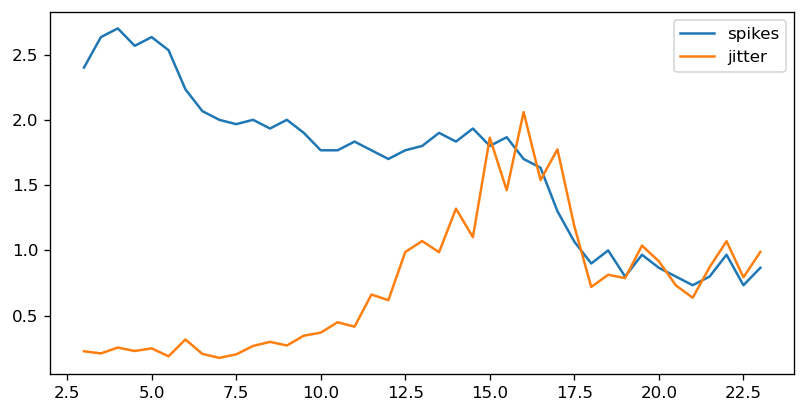

In [12]:
import matplotlib.pyplot as plt
print(interval)
print(pairedspikes)
print(pairedjit)
plt.figure(dpi=120,figsize=(8,4))
plt.plot(interval,pairedspikes,label = 'spikes')
plt.plot(interval,pairedjit,label = 'jitter')
plt.legend()
plt.show()

# x axis: (normal resp-surpressed resp)/normal resp
# y axis: adj resp

[3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0]
[1.0, 1.0333333333333334, 1.3666666666666667, 1.3666666666666667, 1.4666666666666666, 1.7333333333333334, 1.6333333333333333, 1.5666666666666667, 1.5666666666666667, 1.5333333333333334, 1.5333333333333334, 1.4333333333333333, 1.2, 1.3666666666666667, 1.2, 1.1333333333333333, 1.1666666666666667, 1.1666666666666667, 1.2666666666666666, 1.4, 1.5, 1.5, 1.3666666666666667, 1.4, 1.3666666666666667, 1.3333333333333333, 1.2, 0.6, 0.6666666666666666, 0.5, 0.3, 0.3333333333333333, 0.26666666666666666, 0.5, 0.36666666666666664, 0.26666666666666666, 0.4, 0.5, 0.43333333333333335, 0.36666666666666664, 0.5]
[0.2726210230745644, 0.248461935381123, 0.27286545321010414, 0.2570127536826833, 0.25350871122442054, 0.30103525079668353, 0.28836705005176205, 0.2344970978261541, 0.

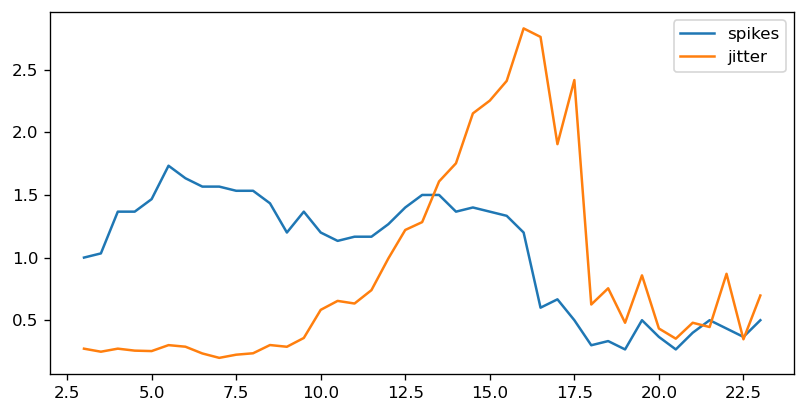

In [7]:
import matplotlib.pyplot as plt
print(interval)
print(pairedspikes)
print(pairedjit)
plt.figure(dpi=120,figsize=(8,4))
plt.plot(interval,pairedspikes,label = 'spikes')
plt.plot(interval,pairedjit,label = 'jitter')
plt.legend()
plt.show()

# x axis: (normal resp-surpressed resp)/normal resp
# y axis: adj resp

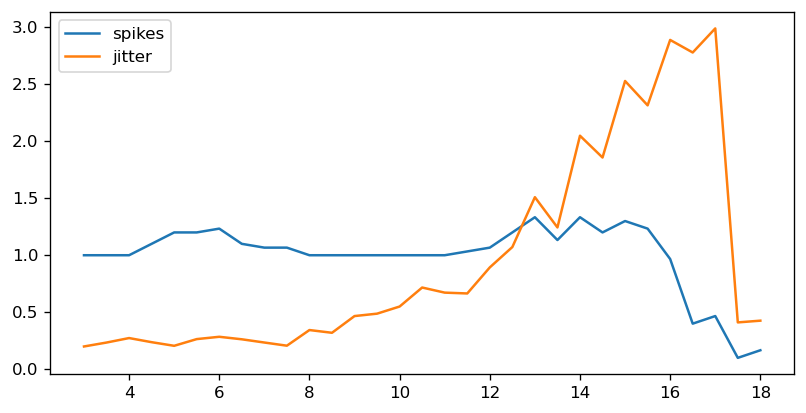

In [6]:
import matplotlib.pyplot as plt

plt.figure(dpi=120,figsize=(8,4))
plt.plot(interval,pairedspikes,label = 'spikes')
plt.plot(interval,pairedjit,label = 'jitter')
plt.legend()
plt.show()

# x axis: (normal resp-surpressed resp)/normal resp
# y axis: adj resp

In [4]:
def SetCoupling(coupling,seed):
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < tcfsP
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = np.random.uniform(0,1) < fsfsP
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    if diff == 0: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs0
                    if diff == 1: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs1
                    if diff == 2: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs2
                    if diff == 3: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs3
                    if diff == 4: 
                        coupling[tc-1,rs-1] = np.random.uniform(0,1) < tcrs4
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < fsrsP
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsP
                        
def CrossCoupling(coupling,seed): 
    np.random.seed(seed)
    
    for i in range(1,tTC+1):                         # TC -> FS synapses returned as array of 0s and 1s
        for j in range(tTC+1,tTC+numFS+1): 
            coupling[i-1,j-1] = 0
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> FS
        for j in range(tTC+1,tTC+numFS+1): 
            if i == j: 
                coupling[i-1,j-1] = 0
            else: 
                coupling[i-1,j-1] = 0
    
    for group1 in range(1,numdir+1):                 # TC -> RS
        for i in range(1,numTC+1): 
            tc = (group1-1)*numTC+i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1):
                    rs = tTC + numFS + (group2-1)*numRS + j
                    coupling[tc-1,rs-1] = 0
    
    for i in range(tTC+1,tTC+numFS+1):               # FS -> RS
        for j in range(tTC+numFS+1,tcells+1): 
            coupling[i-1,j-1] = np.random.uniform(0,1) < rsfsAW
            
            
#     for i in range(tTC+numFS+1,tcells+1): 
#         rs = tTC + numFS + 1 + i
#         for j in range (1,tRS+1): 
#             rs2 = tTC + numFS + 1 + j
#             if rs == rs2:
    
    for group1 in range(1,numdir+1):                 # RS -> RS
        for i in range(1,numRS+1): 
            rs = tTC + numFS + (group1-1)*numRS + i
            for group2 in range(1,numdir+1): 
                if abs(group1-group2) <= 4: 
                    diff = abs(group1-group2)
                else: 
                    maxgroup = group1
                    mingroup = group2
                    if group2 > group1:
                        maxgroup = group2
                        mingroup = group1
                    diff = numdir - maxgroup + mingroup
                for j in range(1,numRS+1): 
                    rs2 = tTC + numFS + (group2-1)*numRS + j
                    if rs == rs2:
                        coupling[rs-1,rs2-1] = 0
                    else: 
                        coupling[rs-1,rs2-1] = np.random.uniform(0,1) < rsrsAW

import scipy as sp

def IGDraw(mu,lmbda):
    np.random.seed()
#     mu=TCmean
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    v=np.random.normal()
    y=v*v
    x=mu + (mu*mu*y)/(2.0*lmbda) - (mu/(2.0*lmbda))*math.sqrt(4.0*mu*lmbda*y + mu*mu*y*y)
    z=np.random.uniform(0,1)
    temp=(mu*mu)/x
    if (z<=(mu/(mu+x))):
        temp=x
    return temp

def setTCspike(tctimes,defdir,TCmu): 
    np.random.seed()
    mu=TCmu
    lmbda=(mu*mu*mu)/(TCsd*TCsd)
    
    for i in range(numTC*(defdir-1)+1,numTC*(defdir-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp0: 
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+1 <= numdir:
        group = defdir+1
    else:
        group = 1
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-1 >= 1:
        group = defdir-1
    else:
        group = numdir
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp1:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+2 <= numdir:
        group = defdir+2
    else:
        group = 2-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-2 >= 1:
        group = defdir-2
    else:
        group = numdir-(2-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp2:
            tctimes[i-1] = IGDraw(mu,lmbda)
            
    if defdir+3 <= numdir:
        group = defdir+3
    else:
        group = 3-(numdir-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    if defdir-3 >= 1:
        group = defdir-3
    else:
        group = numdir-(3-defdir)
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1] = -1.0
        if np.random.uniform(0,1) < tcsp3:
            tctimes[i-1] = IGDraw(mu,lmbda)
    
    if defdir+4 <= numdir:
        group = defdir+4
    else: 
        group = defdir-4
    for i in range(numTC*(group-1)+1,numTC*(group-1)+numTC+1): 
        tctimes[i-1]=-1.0
        if np.random.uniform(0,1) < tcsp4:
            tctimes[i-1] = IGDraw(mu,lmbda)